In [1]:
!pip install -q ftfy regex tqdm
!pip install -q git+https://github.com/openai/CLIP.git


  Preparing metadata (setup.py) ... done


In [2]:
import os
import pandas as pd
import torch
import clip
from PIL import Image
from torchvision import transforms
from transformers import BertTokenizer, BertModel


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


CSV_PATH = "mock_crisis_dataset.csv"
IMAGE_FOLDER = "final_images"

# BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# CLIP
clip_model, clip_preprocess = clip.load("ViT-B/32", device=DEVICE)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [17]:
import zipfile
import os


zip_path = "images.zip"
extract_to = "final_images"


os.makedirs(extract_to, exist_ok=True)

# ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"✅ 解压完成，图片已提取到：{extract_to}/")


✅ 解压完成，图片已提取到：final_images/


In [18]:
import os

# final_images
for root, dirs, files in os.walk("final_images"):
    print(f"📂 当前目录: {root}")
    for name in files[:5]:  # 每个目录只看前5张图
        print("   ", name)


📂 当前目录: final_images
📂 当前目录: final_images/images
    17.jpg
    1.jpg
    36.jpg
    28.jpg
    46.jpg


In [19]:
IMAGE_FOLDER = "final_images/images"


In [21]:
from torch.utils.data import Dataset
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import os

class MultimodalDataset(Dataset):
    def __init__(self, csv_path, image_folder, max_length=128):
        self.data = pd.read_csv(csv_path)
        self.image_folder = image_folder
        self.max_length = max_length


        self.label_encoder = LabelEncoder()
        self.data["label_id"] = self.label_encoder.fit_transform(self.data["label"])


        self.data["full_path"] = self.data["image_path"].apply(lambda x: os.path.join(self.image_folder, x))
        self.data = self.data[self.data["full_path"].apply(os.path.exists)].reset_index(drop=True)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        text = str(row["text"])
        label = row["label_id"]
        image_path = row["full_path"]


        encoding = tokenizer(text, truncation=True, padding="max_length", max_length=self.max_length, return_tensors="pt")


        image = clip_preprocess(Image.open(image_path).convert("RGB"))

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "pixel_values": image,
            "label": torch.tensor(label, dtype=torch.long)
        }


In [22]:
import torch.nn as nn
from transformers import BertModel

class CLIPBERTClassifier(nn.Module):
    def __init__(self, num_labels=4, text_hidden=768, image_hidden=512, fusion_hidden=256):
        super(CLIPBERTClassifier, self).__init__()

        # BERT
        self.text_encoder = BertModel.from_pretrained("bert-base-uncased")

        # CLIP（ clip.load()）
        self.clip_model = clip_model
        for param in self.clip_model.parameters():
            param.requires_grad = False

        self.fusion = nn.Sequential(
            nn.Linear(text_hidden + image_hidden, fusion_hidden),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(fusion_hidden, num_labels)
        )

    def forward(self, input_ids, attention_mask, pixel_values):
        # （BERT）
        text_output = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask)
        text_cls = text_output.last_hidden_state[:, 0, :]  # [CLS]

        # （CLIP）
        with torch.no_grad():  # CLIP
            image_features = self.clip_model.encode_image(pixel_values)

        combined = torch.cat((text_cls, image_features), dim=1)
        logits = self.fusion(combined)
        return logits


In [23]:
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm


def train(model, loader, optimizer, loss_fn):
    model.train()
    total_loss, preds, labels = 0, [], []

    for batch in tqdm(loader):
        for k in batch:
            if k != "label":
                batch[k] = batch[k].to(DEVICE)

        optimizer.zero_grad()
        outputs = model(batch["input_ids"], batch["attention_mask"], batch["pixel_values"])
        loss = loss_fn(outputs, batch["label"].to(DEVICE))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds += outputs.argmax(dim=1).cpu().tolist()
        labels += batch["label"].tolist()

    avg_loss = total_loss / len(loader)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="macro")
    return avg_loss, acc, f1


def evaluate(model, loader):
    model.eval()
    preds, labels = [], []

    with torch.no_grad():
        for batch in loader:
            for k in batch:
                if k != "label":
                    batch[k] = batch[k].to(DEVICE)
            outputs = model(batch["input_ids"], batch["attention_mask"], batch["pixel_values"])
            preds += outputs.argmax(dim=1).cpu().tolist()
            labels += batch["label"].tolist()

    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="macro")
    return acc, f1


In [24]:
from torch.utils.data import DataLoader, random_split
import torch.nn as nn

# dataset
dataset = MultimodalDataset(CSV_PATH, IMAGE_FOLDER)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])

#  DataLoader
train_loader = DataLoader(train_set, batch_size=8, shuffle=True)
val_loader = DataLoader(val_set, batch_size=8)

# model
model = CLIPBERTClassifier(num_labels=len(dataset.label_encoder.classes_)).to(DEVICE)

# optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

# run
for epoch in range(3):
    print(f"\n🌟 Epoch {epoch+1}/3")
    train_loss, train_acc, train_f1 = train(model, train_loader, optimizer, loss_fn)
    val_acc, val_f1 = evaluate(model, val_loader)

    print(f"✅ Train | Loss: {train_loss:.4f} | Acc: {train_acc:.4f} | F1: {train_f1:.4f}")
    print(f"🧪 Val   | Acc: {val_acc:.4f} | F1: {val_f1:.4f}")



🌟 Epoch 1/3


100%|██████████| 5/5 [01:02<00:00, 12.41s/it]


✅ Train | Loss: 1.3967 | Acc: 0.3250 | F1: 0.2663
🧪 Val   | Acc: 0.8000 | F1: 0.6722

🌟 Epoch 2/3


100%|██████████| 5/5 [00:57<00:00, 11.50s/it]


✅ Train | Loss: 1.2051 | Acc: 0.7500 | F1: 0.7189
🧪 Val   | Acc: 0.9000 | F1: 0.8667

🌟 Epoch 3/3


100%|██████████| 5/5 [00:56<00:00, 11.39s/it]


✅ Train | Loss: 0.9916 | Acc: 0.9250 | F1: 0.9233
🧪 Val   | Acc: 1.0000 | F1: 1.0000


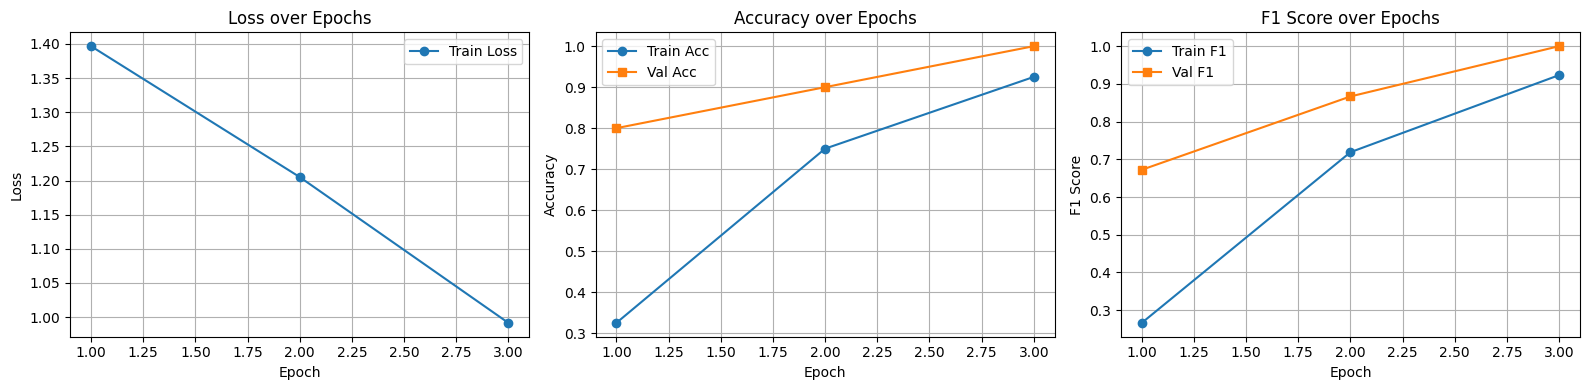

In [27]:
import matplotlib.pyplot as plt

train_loss_list = [1.3967, 1.2051, 0.9916]
train_acc_list = [0.3250, 0.7500, 0.9250]
train_f1_list = [0.2663, 0.7189, 0.9233]

val_acc_list = [0.8000, 0.9000, 1.0000]
val_f1_list = [0.6722, 0.8667, 1.0000]

epochs = list(range(1, len(train_loss_list) + 1))


plt.figure(figsize=(16, 4))

# 图1：Loss
plt.subplot(1, 3, 1)
plt.plot(epochs, train_loss_list, marker='o', label='Train Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# 图2：Accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs, train_acc_list, marker='o', label='Train Acc')
plt.plot(epochs, val_acc_list, marker='s', label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# 图3：F1 Score
plt.subplot(1, 3, 3)
plt.plot(epochs, train_f1_list, marker='o', label='Train F1')
plt.plot(epochs, val_f1_list, marker='s', label='Val F1')
plt.title('F1 Score over Epochs')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [25]:
# save
torch.save(model.state_dict(), "bert_clip_model.pth")
print("✅ 模型已保存为 bert_clip_model.pth")


✅ 模型已保存为 bert_clip_model.pth


In [26]:

model.load_state_dict(torch.load("bert_clip_model.pth", map_location=DEVICE))
model.eval()
print("✅ model use succesful")


✅ 模型已成功加载
